In [15]:
# Standard Imports
import pandas as pd
%matplotlib inline 
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot


# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


# Utilities
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

from imblearn.under_sampling import RandomUnderSampler


In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
X_train = pd.read_csv('./drive/MyDrive/cars/6-X_train_FINAL.csv')
X_test = pd.read_csv('./drive/MyDrive/cars/6-X_test_FINAL.csv')
X_train=X_train.drop(['MAKE', 'VIN'], axis=1)
X_test=X_test.drop(['MAKE', 'VIN'], axis=1)

In [18]:
# Dropping Nulls
X_train = X_train.dropna(axis=0)
X_test = X_test.dropna(axis=0)

In [19]:
X_train = X_train[X_train['GVW_TYPE'].notna()]
X_test = X_test[X_test['GVW_TYPE'].notna()]

X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(int)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(int)

X_train['VEHICLE_TYPE'] = X_train['VEHICLE_TYPE'].astype(str)
X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(str)
X_train['FINAL_CYL'] = X_train['FINAL_CYL'].astype(str)
X_train['OBD_MIL_STATUS'] = X_train['OBD_MIL_STATUS'].astype(bool)

X_test['VEHICLE_TYPE'] = X_test['VEHICLE_TYPE'].astype(str)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(str)
X_test['FINAL_CYL'] = X_test['FINAL_CYL'].astype(str)
X_test['OBD_MIL_STATUS'] = X_test['OBD_MIL_STATUS'].astype(bool)

In [20]:
X_train.OBD_MIL_STATUS.value_counts()


True     115712
False      3597
Name: OBD_MIL_STATUS, dtype: int64

In [21]:
# getting target feature
y_train = X_train['OVERALL_RESULT']
X_train = X_train.drop('OVERALL_RESULT', axis='columns')
y_train = LabelEncoder().fit_transform(y_train)

y_test = X_test['OVERALL_RESULT']
X_test = X_test.drop('OVERALL_RESULT', axis='columns')
y_test = LabelEncoder().fit_transform(y_test)

In [22]:
print(len(X_train))
print(len(y_train))

119309
119309


In [23]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119309 entries, 0 to 126744
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   FINAL_CYL       119309 non-null  object 
 1   CAR_AGE         119309 non-null  float64
 2   GVW_TYPE        119309 non-null  object 
 3   TRANS_TYPE      119309 non-null  object 
 4   DUAL_EXHAUST    119309 non-null  object 
 5   FUEL_TYPE       119309 non-null  object 
 6   VEHICLE_TYPE    119309 non-null  object 
 7   OBD_MIL_STATUS  119309 non-null  bool   
 8   MODEL_YEAR      119309 non-null  int64  
 9   ODOMETER        119309 non-null  float64
 10  AVG_MIL_YEARLY  119309 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 10.1+ MB


In [25]:
categorical_columns = X_train[['ODOMETER','AVG_MIL_YEARLY']].select_dtypes(include='object').columns
len(categorical_columns)


0

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report


def cross_validate(
    cv,
    balancing_technique,
    model,
    nameTest,
    Comb_X_train,
    Comb_X_test):

    categorical_columns = Comb_X_train.select_dtypes(include='object').columns

    pipeline = make_pipeline(balancing_technique, model)

    if (len(categorical_columns) > 0):
        print(':::::::CATEGORICAL FEATURES FOUND:::::::')
        cat_pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )

        preprocessor_linear = make_column_transformer(
            (cat_pipe, categorical_columns),
            n_jobs=2,
        )

        pipeline = make_pipeline(
            balancing_technique, preprocessor_linear, model)

    train_acc = []
    test_acc = []
    test_prec = []
    test_recall = []
    test_f1 = []

    for train_ind, val_ind in cv.split(Comb_X_train, y_train):
        X_t, y_t = Comb_X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))

        X_val, y_val = Comb_X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))

        y_pred = pipeline.predict(Comb_X_test)
        precision = precision_score(y_test, y_pred, pos_label=0)
        recall = recall_score(y_test, y_pred, pos_label=0)
        F1Sc = f1_score(y_test, y_pred, pos_label=0)
        test_prec.append(precision)
        test_recall.append(recall)
        test_f1.append(F1Sc)

    print(classification_report(y_val, y_hat_val))
    cm = confusion_matrix(y_val, y_hat_val)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('Test Precision: {}'.format(np.mean(test_prec)))
    print('Test Recall: {}'.format(np.mean(test_recall)))
    print('Test F1: {}'.format(np.mean(test_f1)))
    print('\n')

    return [nameTest,
        np.mean(train_acc),
        np.mean(test_acc),
        np.mean(test_prec),
        np.mean(test_recall),
        np.mean(test_f1)]

In [27]:
import itertools as iter

def permutationsCars(lst):
    comb = (iter.combinations(lst, l) for l in range(len(lst) + 1))
    return list(iter.chain.from_iterable(comb))

def listing(lst):
  return list(lst)

#Number of values to use if automatically
var = 10

#ENTER ALL POSSIBLE COLUMNS HERE
listsTries = X_train.columns
permutations = permutationsCars(X_train.columns)
iterationsIndex = permutations[len(listsTries)+1:]

#AUTOMATIC FROM DF
#permutations = permutationsCars(X_train.columns[:var])
#iterationsIndex = permutations[var+1:]

ColumnNamesPermutation = []
for x in iterationsIndex:
  ColumnNamesPermutation.append(listing(x))

In [28]:
ColumnNamesPermutation

[['FINAL_CYL', 'CAR_AGE'],
 ['FINAL_CYL', 'GVW_TYPE'],
 ['FINAL_CYL', 'TRANS_TYPE'],
 ['FINAL_CYL', 'DUAL_EXHAUST'],
 ['FINAL_CYL', 'FUEL_TYPE'],
 ['CAR_AGE', 'GVW_TYPE'],
 ['CAR_AGE', 'TRANS_TYPE'],
 ['CAR_AGE', 'DUAL_EXHAUST'],
 ['CAR_AGE', 'FUEL_TYPE'],
 ['GVW_TYPE', 'TRANS_TYPE'],
 ['GVW_TYPE', 'DUAL_EXHAUST'],
 ['GVW_TYPE', 'FUEL_TYPE'],
 ['TRANS_TYPE', 'DUAL_EXHAUST'],
 ['TRANS_TYPE', 'FUEL_TYPE'],
 ['DUAL_EXHAUST', 'FUEL_TYPE'],
 ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE'],
 ['FINAL_CYL', 'CAR_AGE', 'TRANS_TYPE'],
 ['FINAL_CYL', 'CAR_AGE', 'DUAL_EXHAUST'],
 ['FINAL_CYL', 'CAR_AGE', 'FUEL_TYPE'],
 ['FINAL_CYL', 'GVW_TYPE', 'TRANS_TYPE'],
 ['FINAL_CYL', 'GVW_TYPE', 'DUAL_EXHAUST'],
 ['FINAL_CYL', 'GVW_TYPE', 'FUEL_TYPE'],
 ['FINAL_CYL', 'TRANS_TYPE', 'DUAL_EXHAUST'],
 ['FINAL_CYL', 'TRANS_TYPE', 'FUEL_TYPE'],
 ['FINAL_CYL', 'DUAL_EXHAUST', 'FUEL_TYPE'],
 ['CAR_AGE', 'GVW_TYPE', 'TRANS_TYPE'],
 ['CAR_AGE', 'GVW_TYPE', 'DUAL_EXHAUST'],
 ['CAR_AGE', 'GVW_TYPE', 'FUEL_TYPE'],
 ['CAR_AGE', 'T

:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


None
Training Accuracy: 0.4375822390532558


Validation Accuracy: 0.4373350118025468
Test Precision: 0.9509193555918098
Test Recall: 0.4190554738767167
Test F1: 0.581730849828724


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.496331096196868
Accuracy:  0.502200243074473
Precision:  0.946986511866143
F1:  0.651303428839831


None
Training Accuracy: 0.490922703942415


Validation Accuracy: 0.4904157421862633
Test Precision: 0.9504504268909564
Test Recall: 0.47967153153799263
Test F1: 0.6374745539500262


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.37472035794183445
Accuracy:  0.39688194124303255
Precision:  0.9526788761233079
F1:  0.5378761118782313


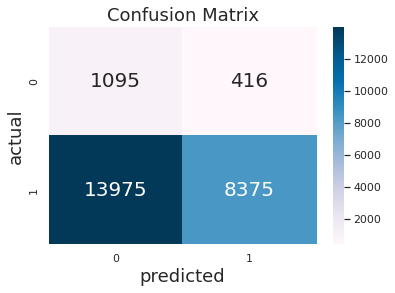

None
Training Accuracy: 0.3969775980915658


Validation Accuracy: 0.39697759518851095
Test Precision: 0.9563156558726311
Test Recall: 0.3711406748664252
Test F1: 0.5347466786775008


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


None
Training Accuracy: 0.43791540818077


Validation Accuracy: 0.43760322067020246
Test Precision: 0.9508347785415129
Test Recall: 0.4193997202997813
Test F1: 0.582044283528292


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.42787472035794183
Accuracy:  0.44218599388122876
Precision:  0.9481459448740829
F1:  0.5896534714514737


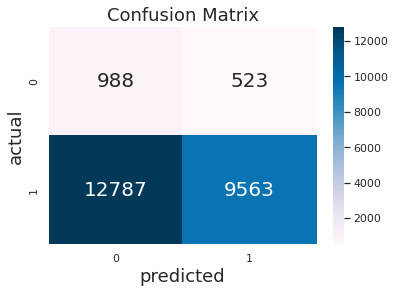

None
Training Accuracy: 0.439681829092196


Validation Accuracy: 0.43948908042908297
Test Precision: 0.9510337243500361
Test Recall: 0.42161580664825904
Test F1: 0.584215111127101


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8165548098434005
Accuracy:  0.7775030384309124
Precision:  0.937869366360039
F1:  0.8730177712932621


None
Training Accuracy: 0.766480290572521


Validation Accuracy: 0.7664301190431517
Test Precision: 0.9376603049666399
Test Recall: 0.8035572130383333
Test F1: 0.865404311423611


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


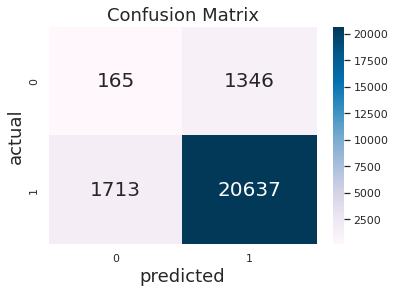

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9950335570469798
Accuracy:  0.9324839696576003
Precision:  0.9368128396309869
F1:  0.9650458894747119


None
Training Accuracy: 0.9323269829586309


Validation Accuracy: 0.9323269841921855
Test Precision: 0.9365669121124096
Test Recall: 0.994298418617994
Test F1: 0.9645695997773641


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7421476510067114
Accuracy:  0.7143455848455639
Precision:  0.9403061224489796
F1:  0.8295573893473368


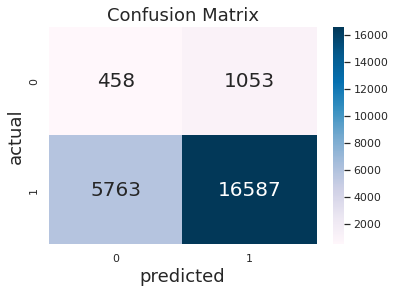

None
Training Accuracy: 0.7046576281713841


Validation Accuracy: 0.7045823011112634
Test Precision: 0.9409125022739921
Test Recall: 0.7290852368487108
Test F1: 0.8215207708593806


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8122595078299776
Accuracy:  0.7739407401198609
Precision:  0.9380942538238942
F1:  0.8706536856745479


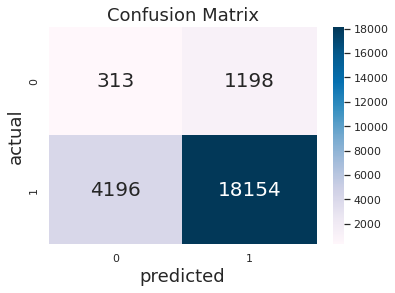

None
Training Accuracy: 0.7626582819150438


Validation Accuracy: 0.7626248758757869
Test Precision: 0.9378577831335854
Test Recall: 0.7988094811202352
Test F1: 0.8627250122213258


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.03646532438478747
Accuracy:  0.095679141695654
Precision:  0.9498834498834499
F1:  0.07023440193036884


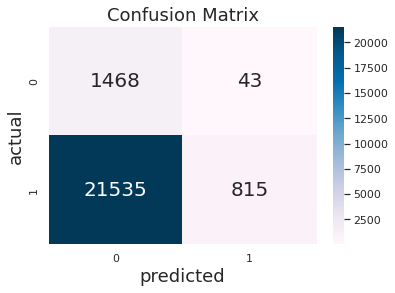

None
Training Accuracy: 0.4941211433422322


Validation Accuracy: 0.4939828654692959
Test Precision: 0.9501339543296737
Test Recall: 0.49251622619858715
Test F1: 0.5396876671575146


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9195973154362416
Accuracy:  0.8686140564100415
Precision:  0.9388789913663149
F1:  0.9291381297891096


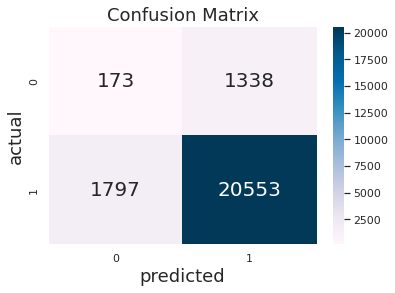

None
Training Accuracy: 0.8690207777668147


Validation Accuracy: 0.8690207745709195
Test Precision: 0.9393594776037272
Test Recall: 0.9182056155197762
Test F1: 0.9286620969789288


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


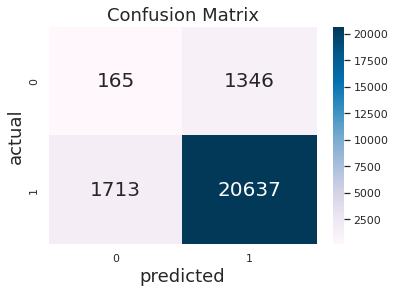

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


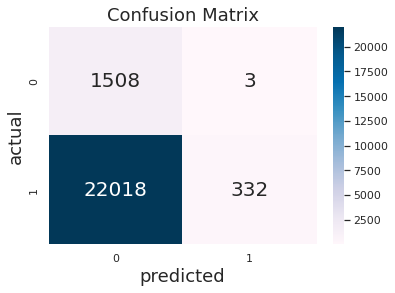

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.496331096196868
Accuracy:  0.502200243074473
Precision:  0.946986511866143
F1:  0.651303428839831


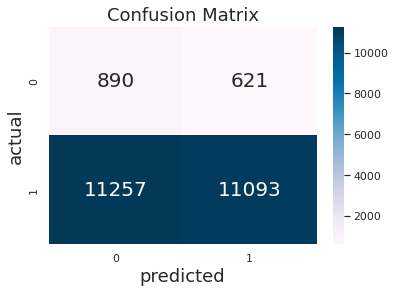

None
Training Accuracy: 0.490922703942415


Validation Accuracy: 0.4904157421862633
Test Precision: 0.9504504268909564
Test Recall: 0.47967153153799263
Test F1: 0.6374745539500262


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.37472035794183445
Accuracy:  0.39688194124303255
Precision:  0.9526788761233079
F1:  0.5378761118782313


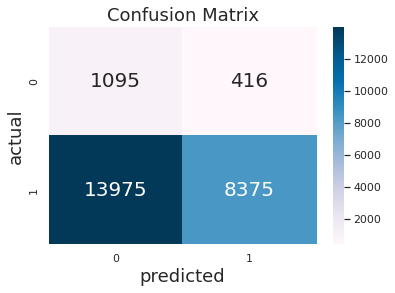

None
Training Accuracy: 0.3969775980915658


Validation Accuracy: 0.39697759518851095
Test Precision: 0.9563156558726311
Test Recall: 0.3711406748664252
Test F1: 0.5347466786775008


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


None
Training Accuracy: 0.43791540818077


Validation Accuracy: 0.43760322067020246
Test Precision: 0.9508347785415129
Test Recall: 0.4193997202997813
Test F1: 0.582044283528292


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.42787472035794183
Accuracy:  0.44218599388122876
Precision:  0.9481459448740829
F1:  0.5896534714514737


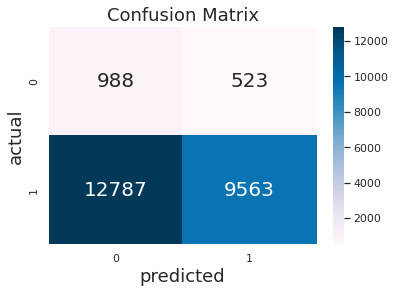

None
Training Accuracy: 0.439681829092196


Validation Accuracy: 0.43948908042908297
Test Precision: 0.9510337243500361
Test Recall: 0.42161580664825904
Test F1: 0.584215111127101


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.44715883668903805
Accuracy:  0.4607099450986966
Precision:  0.9512659432705121
F1:  0.6083515948380813


None
Training Accuracy: 0.4495364750177589


Validation Accuracy: 0.44917828103214397
Test Precision: 0.9557390551351427
Test Recall: 0.43060207265033884
Test F1: 0.5936285704765991


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.496420581655481
Accuracy:  0.5022840618582625
Precision:  0.946995561625128
F1:  0.651382610227206


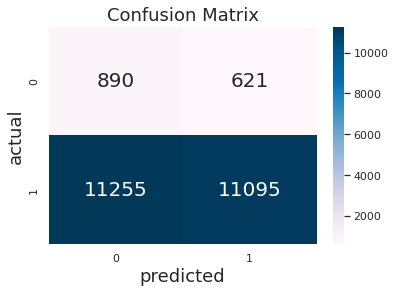

None
Training Accuracy: 0.49127473146202966


Validation Accuracy: 0.49068395175644836
Test Precision: 0.9504614422766299
Test Recall: 0.48018072937210887
Test F1: 0.6379153546899538


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.49776286353467564
Accuracy:  0.5035413436151042
Precision:  0.9471309381917249
F1:  0.6525692163303614


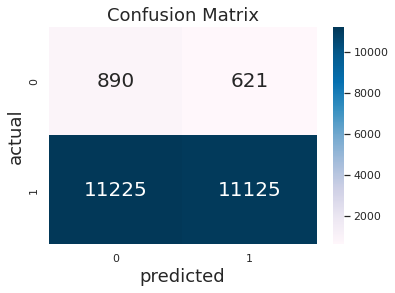

None
Training Accuracy: 0.4924355822975274


Validation Accuracy: 0.4919411913615256
Test Precision: 0.9505405140155883
Test Recall: 0.48155054326388635
Test F1: 0.6391560828502763


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.37480984340044743
Accuracy:  0.396965760026822
Precision:  0.9526896394859548
F1:  0.5379700093118839


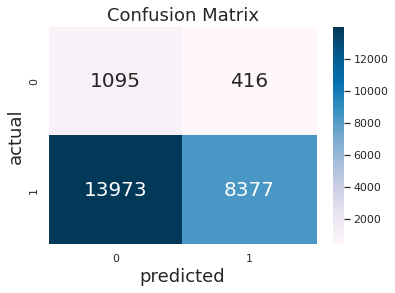

None
Training Accuracy: 0.3972646682272112


Validation Accuracy: 0.3971871340688964
Test Precision: 0.9562972027382018
Test Recall: 0.37144189048660664
Test F1: 0.5350543604821818


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3767337807606264
Accuracy:  0.3987678638782951
Precision:  0.9529198732458126
F1:  0.539985891104983


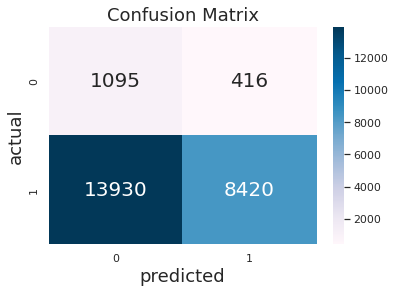

None
Training Accuracy: 0.39903947086333164


Validation Accuracy: 0.39904784819263994
Test Precision: 0.9564215411229375
Test Recall: 0.3736579768350845
Test F1: 0.5373715824682398


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.42787472035794183
Accuracy:  0.44218599388122876
Precision:  0.9481459448740829
F1:  0.5896534714514737


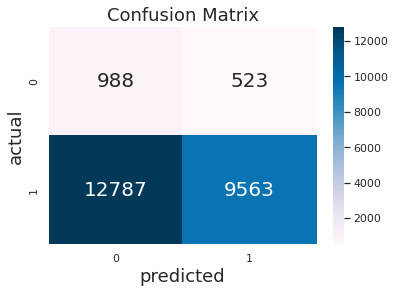

None
Training Accuracy: 0.4399479453002891


Validation Accuracy: 0.4396567109713677
Test Precision: 0.9509828679372699
Test Recall: 0.4218453042636353
Test F1: 0.5844241321900051


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7421476510067114
Accuracy:  0.7143455848455639
Precision:  0.9403061224489796
F1:  0.8295573893473368


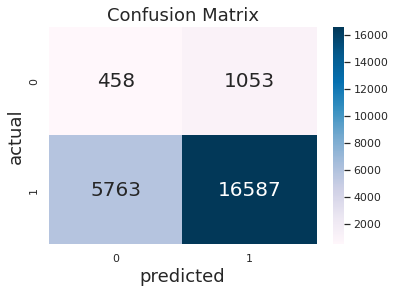

None
Training Accuracy: 0.7046576281713841


Validation Accuracy: 0.7045823011112634
Test Precision: 0.9409125022739921
Test Recall: 0.7290852368487108
Test F1: 0.8215207708593806


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8122595078299776
Accuracy:  0.7739407401198609
Precision:  0.9380942538238942
F1:  0.8706536856745479


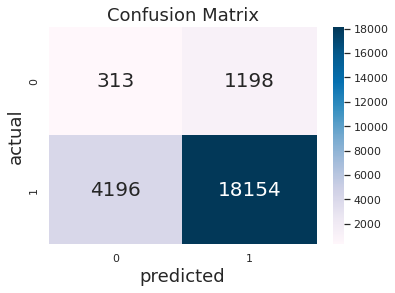

None
Training Accuracy: 0.7626582819150438


Validation Accuracy: 0.7626248758757869
Test Precision: 0.9378577831335854
Test Recall: 0.7988094811202352
Test F1: 0.8627250122213258


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.03646532438478747
Accuracy:  0.095679141695654
Precision:  0.9498834498834499
F1:  0.07023440193036884


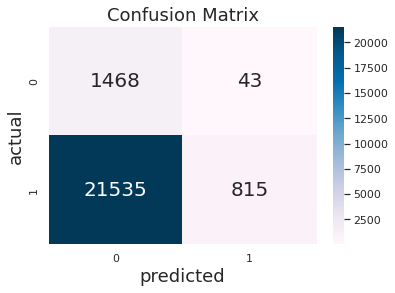

None
Training Accuracy: 0.4941211433422322


Validation Accuracy: 0.4939828654692959
Test Precision: 0.9501339543296737
Test Recall: 0.49251622619858715
Test F1: 0.5396876671575146


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9195973154362416
Accuracy:  0.8686140564100415
Precision:  0.9388789913663149
F1:  0.9291381297891096


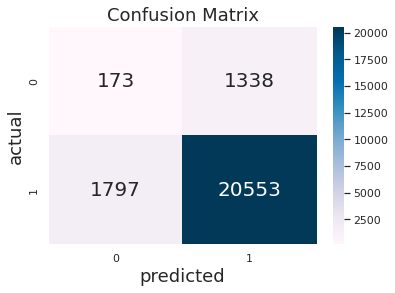

None
Training Accuracy: 0.8690207777668147


Validation Accuracy: 0.8690207745709195
Test Precision: 0.9393594776037272
Test Recall: 0.9182056155197762
Test F1: 0.9286620969789288


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


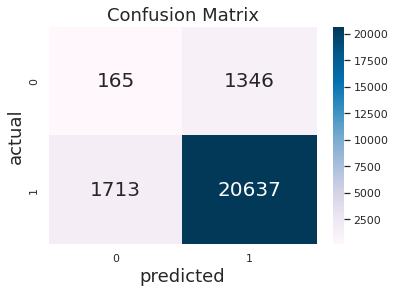

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


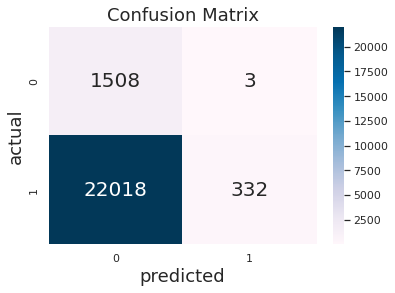

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7390604026845637
Accuracy:  0.7117891119399857
Precision:  0.9404999145931788
F1:  0.8277002480394858


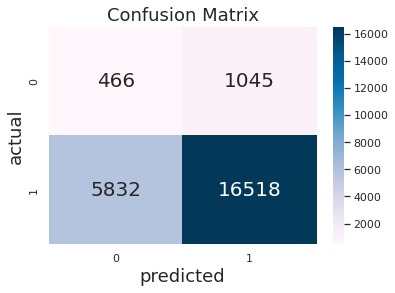

None
Training Accuracy: 0.7017156873250424


Validation Accuracy: 0.7016403636670182
Test Precision: 0.9410580386462353
Test Recall: 0.7253845878007674
Test F1: 0.8192192922015143


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7429530201342281
Accuracy:  0.715099953899669
Precision:  0.9403669724770642
F1:  0.8300839832033594


None
Training Accuracy: 0.7055167419232472


Validation Accuracy: 0.7054456047267949
Test Precision: 0.940997752366864
Test Recall: 0.7302040377236705
Test F1: 0.8222635064223992


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.036778523489932886
Accuracy:  0.09597250743891707
Precision:  0.9502890173410404
F1:  0.07081628257592074


None
Training Accuracy: 0.4919335410557933


Validation Accuracy: 0.4917785262971037
Test Precision: 0.9493282093422742
Test Recall: 0.48983397281887625
Test F1: 0.5384886609269489


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9195973154362416
Accuracy:  0.8686140564100415
Precision:  0.9388789913663149
F1:  0.9291381297891096


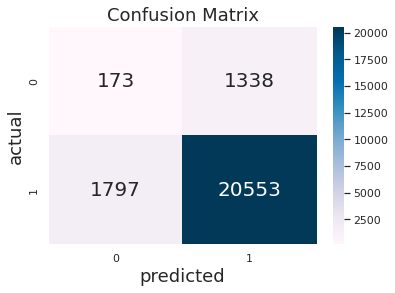

None
Training Accuracy: 0.8690459225457378


Validation Accuracy: 0.8690459191522624
Test Precision: 0.9393617021276596
Test Recall: 0.9182414745221787
Test F1: 0.9286815239269588


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.44715883668903805
Accuracy:  0.4607099450986966
Precision:  0.9512659432705121
F1:  0.6083515948380813


None
Training Accuracy: 0.4495364750177589


Validation Accuracy: 0.44917828103214397
Test Precision: 0.9557390551351427
Test Recall: 0.43060207265033884
Test F1: 0.5936285704765991


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.496420581655481
Accuracy:  0.5022840618582625
Precision:  0.946995561625128
F1:  0.651382610227206


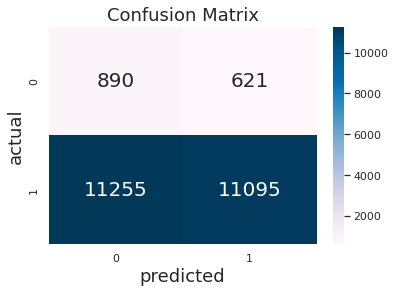

None
Training Accuracy: 0.49127473146202966


Validation Accuracy: 0.49068395175644836
Test Precision: 0.9504614422766299
Test Recall: 0.48018072937210887
Test F1: 0.6379153546899538


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.49776286353467564
Accuracy:  0.5035413436151042
Precision:  0.9471309381917249
F1:  0.6525692163303614


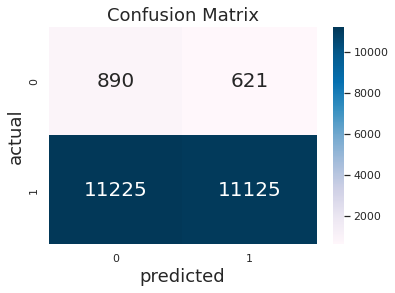

None
Training Accuracy: 0.4924355822975274


Validation Accuracy: 0.4919411913615256
Test Precision: 0.9505405140155883
Test Recall: 0.48155054326388635
Test F1: 0.6391560828502763


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.37480984340044743
Accuracy:  0.396965760026822
Precision:  0.9526896394859548
F1:  0.5379700093118839


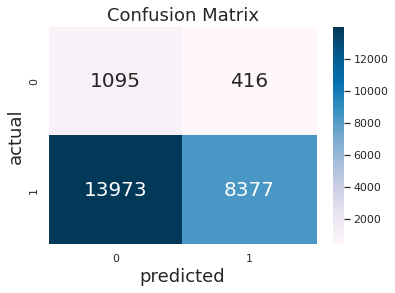

None
Training Accuracy: 0.3972646682272112


Validation Accuracy: 0.3971871340688964
Test Precision: 0.9562972027382018
Test Recall: 0.37144189048660664
Test F1: 0.5350543604821818


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3767337807606264
Accuracy:  0.3987678638782951
Precision:  0.9529198732458126
F1:  0.539985891104983


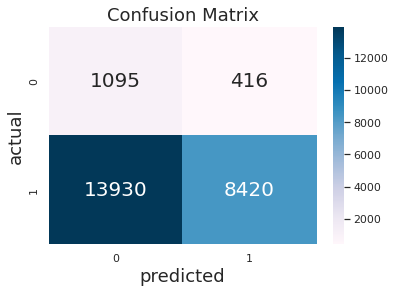

None
Training Accuracy: 0.39903947086333164


Validation Accuracy: 0.39904784819263994
Test Precision: 0.9564215411229375
Test Recall: 0.3736579768350845
Test F1: 0.5373715824682398


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.42787472035794183
Accuracy:  0.44218599388122876
Precision:  0.9481459448740829
F1:  0.5896534714514737


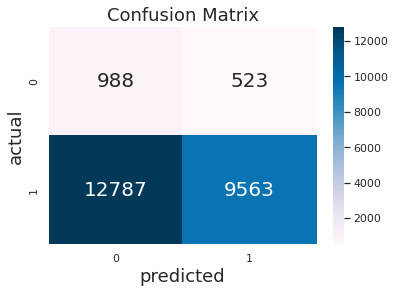

None
Training Accuracy: 0.4399479453002891


Validation Accuracy: 0.4396567109713677
Test Precision: 0.9509828679372699
Test Recall: 0.4218453042636353
Test F1: 0.5844241321900051


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.44738255033557045
Accuracy:  0.46091949205817023
Precision:  0.9512891256778613
F1:  0.6085633425641338


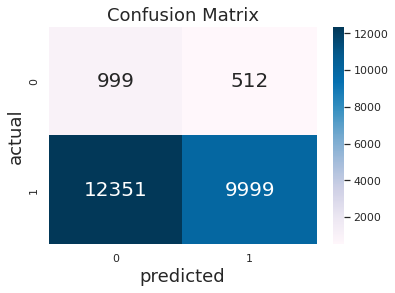

None
Training Accuracy: 0.4500100356025708


Validation Accuracy: 0.44958897761706523
Test Precision: 0.9556946319053395
Test Recall: 0.4312188474916628
Test F1: 0.5941962391759813


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.44863534675615213
Accuracy:  0.4620929550312225
Precision:  0.9514185406585065
F1:  0.6097479400407431


None
Training Accuracy: 0.45115202784838804


Validation Accuracy: 0.4508294534653846
Test Precision: 0.9557687879245457
Test Recall: 0.4326030049844013
Test F1: 0.5955352232917286


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.49798657718120803
Accuracy:  0.5037508905745778
Precision:  0.9471534337503191
F1:  0.6527667810328143


None
Training Accuracy: 0.4929384783589593


Validation Accuracy: 0.4923602694735611
Test Precision: 0.9504982149588228
Test Recall: 0.4822031771076129
Test F1: 0.6397087667213912


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3768232662192394
Accuracy:  0.3988516826620846
Precision:  0.9529305272686128
F1:  0.5400795177632423


None
Training Accuracy: 0.39933282721017277


Validation Accuracy: 0.39925738707302544
Test Precision: 0.9563824403979189
Test Recall: 0.3739305052533438
Test F1: 0.5376455031870426


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7390604026845637
Accuracy:  0.7117891119399857
Precision:  0.9404999145931788
F1:  0.8277002480394858


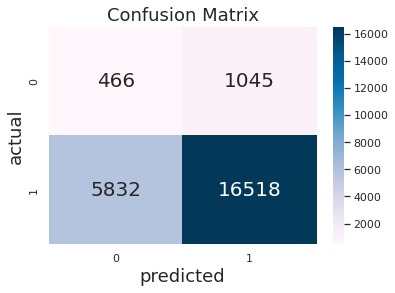

None
Training Accuracy: 0.7017156873250424


Validation Accuracy: 0.7016403636670182
Test Precision: 0.9410580386462353
Test Recall: 0.7253845878007674
Test F1: 0.8192192922015143


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7429530201342281
Accuracy:  0.715099953899669
Precision:  0.9403669724770642
F1:  0.8300839832033594


None
Training Accuracy: 0.7055167419232472


Validation Accuracy: 0.7054456047267949
Test Precision: 0.940997752366864
Test Recall: 0.7302040377236705
Test F1: 0.8222635064223992


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.036778523489932886
Accuracy:  0.09597250743891707
Precision:  0.9502890173410404
F1:  0.07081628257592074


None
Training Accuracy: 0.4919335410557933


Validation Accuracy: 0.4917785262971037
Test Precision: 0.9493282093422742
Test Recall: 0.48983397281887625
Test F1: 0.5384886609269489


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9195973154362416
Accuracy:  0.8686140564100415
Precision:  0.9388789913663149
F1:  0.9291381297891096


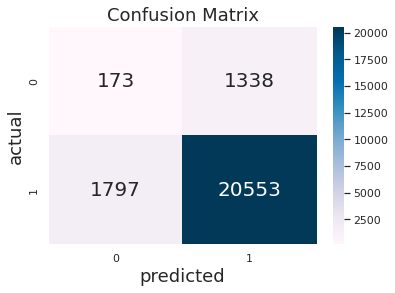

None
Training Accuracy: 0.8690459225457378


Validation Accuracy: 0.8690459191522624
Test Precision: 0.9393617021276596
Test Recall: 0.9182414745221787
Test F1: 0.9286815239269588


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7398657718120806
Accuracy:  0.7125434809940908
Precision:  0.9405608327171379
F1:  0.8282286944980091


None
Training Accuracy: 0.7025852780736116


Validation Accuracy: 0.7025204303367781
Test Precision: 0.9411462604059823
Test Recall: 0.7265392476781296
Test F1: 0.8199890699956531


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.44738255033557045
Accuracy:  0.46091949205817023
Precision:  0.9512891256778613
F1:  0.6085633425641338


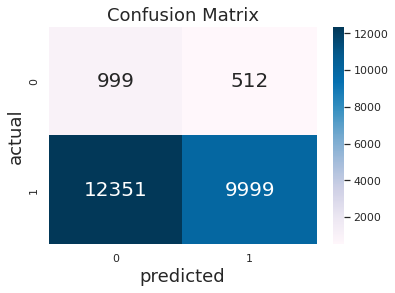

None
Training Accuracy: 0.4500100356025708


Validation Accuracy: 0.44958897761706523
Test Precision: 0.9556946319053395
Test Recall: 0.4312188474916628
Test F1: 0.5941962391759813


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.44863534675615213
Accuracy:  0.4620929550312225
Precision:  0.9514185406585065
F1:  0.6097479400407431


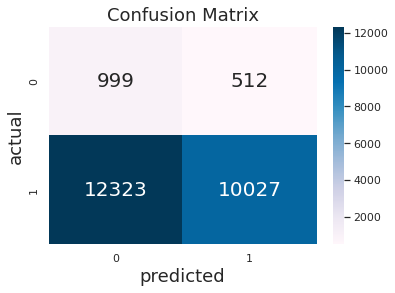

None
Training Accuracy: 0.45115202784838804


Validation Accuracy: 0.4508294534653846
Test Precision: 0.9557687879245457
Test Recall: 0.4326030049844013
Test F1: 0.5955352232917286


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.49798657718120803
Accuracy:  0.5037508905745778
Precision:  0.9471534337503191
F1:  0.6527667810328143


None
Training Accuracy: 0.4929384783589593


Validation Accuracy: 0.4923602694735611
Test Precision: 0.9504982149588228
Test Recall: 0.4822031771076129
Test F1: 0.6397087667213912


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3768232662192394
Accuracy:  0.3988516826620846
Precision:  0.9529305272686128
F1:  0.5400795177632423


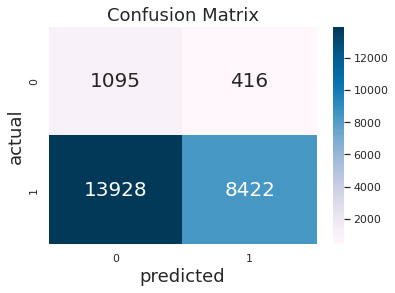

None
Training Accuracy: 0.39933282721017277


Validation Accuracy: 0.39925738707302544
Test Precision: 0.9563824403979189
Test Recall: 0.3739305052533438
Test F1: 0.5376455031870426


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4488590604026846
Accuracy:  0.4623025019906961
Precision:  0.9514415781487102
F1:  0.6099592630874933


None
Training Accuracy: 0.45158787120993227


Validation Accuracy: 0.4511898608876204
Test Precision: 0.9557497739218199
Test Recall: 0.43316957722236166
Test F1: 0.5960587635375497


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7398657718120806
Accuracy:  0.7125434809940908
Precision:  0.9405608327171379
F1:  0.8282286944980091


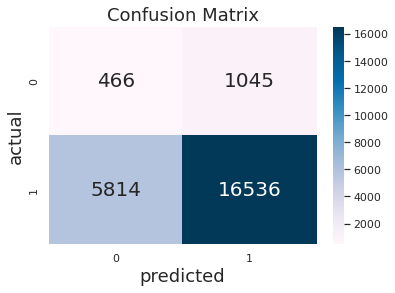

None
Training Accuracy: 0.7025852780736116


Validation Accuracy: 0.7025204303367781
Test Precision: 0.9411462604059823
Test Recall: 0.7265392476781296
Test F1: 0.8199890699956531


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4488590604026846
Accuracy:  0.4623025019906961
Precision:  0.9514415781487102
F1:  0.6099592630874933


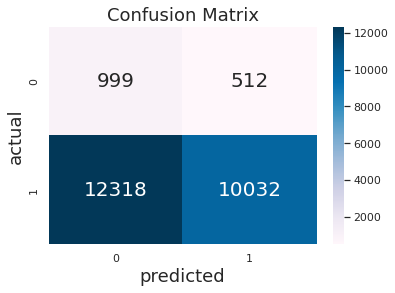

None
Training Accuracy: 0.45158787120993227


Validation Accuracy: 0.4511898608876204
Test Precision: 0.9557497739218199
Test Recall: 0.43316957722236166
Test F1: 0.5960587635375497




In [29]:
Models = []
counter = 0
#Random Forest as model chosen
model = RandomForestClassifier(n_estimators=100, random_state=0)

for i,x in enumerate(ColumnNamesPermutation):

  #Balancing technique: UnderSampling
  balancing_technique = RandomUnderSampler(random_state=0)
  nameTest = str(ColumnNamesPermutation[i])

  #Evaluating the model

  Models.append(cross_validate(
    KFold(),
    balancing_technique,
    model,
    nameTest, 
    X_train[ColumnNamesPermutation[i]],
    X_test[ColumnNamesPermutation[i]]))
  counter += 1

In [36]:
ModelsDf =pd.DataFrame(Models)
ModelsDf.columns = ["Variables_Used","TrainAccuracy","ValAccuracy","Precision","Recall","F1Score"]


Variables_Used  ...   F1Score
0                            ['FINAL_CYL', 'CAR_AGE']  ...  0.581731
1                           ['FINAL_CYL', 'GVW_TYPE']  ...  0.637475
2                         ['FINAL_CYL', 'TRANS_TYPE']  ...  0.534747
3                       ['FINAL_CYL', 'DUAL_EXHAUST']  ...  0.582044
4                          ['FINAL_CYL', 'FUEL_TYPE']  ...  0.584215
5                             ['CAR_AGE', 'GVW_TYPE']  ...  0.865404
6                           ['CAR_AGE', 'TRANS_TYPE']  ...  0.930963
7                         ['CAR_AGE', 'DUAL_EXHAUST']  ...  0.964570
8                            ['CAR_AGE', 'FUEL_TYPE']  ...  0.030013
9                          ['GVW_TYPE', 'TRANS_TYPE']  ...  0.821521
10                       ['GVW_TYPE', 'DUAL_EXHAUST']  ...  0.862725
11                          ['GVW_TYPE', 'FUEL_TYPE']  ...  0.539688
12                     ['TRANS_TYPE', 'DUAL_EXHAUST']  ...  0.928662
13                        ['TRANS_TYPE', 'FUEL_TYPE']  ...  0.930963
14                      ['DUAL_EXHAUST', 'FUEL_TYPE']  ...  0.030013
15               ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE']  ...  0.637475
16             ['FINAL_CYL', 'CAR_AGE', 'TRANS_TYPE']  ...  0.534747
17           ['FINAL_CYL', 'CAR_AGE', 'DUAL_EXHAUST']  ...  0.582044
18              ['FINAL_CYL', 'CAR_AGE', 'FUEL_TYPE']  ...  0.584215
19            ['FINAL_CYL', 'GVW_TYPE', 'TRANS_TYPE']  ...  0.593629
20          ['FINAL_CYL', 'GVW_TYPE', 'DUAL_EXHAUST']  ...  0.637915
21             ['FINAL_CYL', 'GVW_TYPE', 'FUEL_TYPE']  ...  0.639156
22        ['FINAL_CYL', 'TRANS_TYPE', 'DUAL_EXHAUST']  ...  0.535054
23           ['FINAL_CYL', 'TRANS_TYPE', 'FUEL_TYPE']  ...  0.537372
24         ['FINAL_CYL', 'DUAL_EXHAUST', 'FUEL_TYPE']  ...  0.584424
25              ['CAR_AGE', 'GVW_TYPE', 'TRANS_TYPE']  ...  0.821521
26            ['CAR_AGE', 'GVW_TYPE', 'DUAL_EXHAUST']  ...  0.862725
27               ['CAR_AGE', 'GVW_TYPE', 'FUEL_TYPE']  ...  0.539688
28          ['CAR_AGE', 'TRANS_TYPE', 'DUAL_EXHAUST']  ...  0.928662
29             ['CAR_AGE', 'TRANS_TYPE', 'FUEL_TYPE']  ...  0.930963
30           ['CAR_AGE', 'DUAL_EXHAUST', 'FUEL_TYPE']  ...  0.030013
31         ['GVW_TYPE', 'TRANS_TYPE', 'DUAL_EXHAUST']  ...  0.819219
32            ['GVW_TYPE', 'TRANS_TYPE', 'FUEL_TYPE']  ...  0.822264
33          ['GVW_TYPE', 'DUAL_EXHAUST', 'FUEL_TYPE']  ...  0.538489
34        ['TRANS_TYPE', 'DUAL_EXHAUST', 'FUEL_TYPE']  ...  0.928682
35  ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE', 'TRANS_TY...  ...  0.593629
36  ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE', 'DUAL_EXH...  ...  0.637915
37  ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE', 'FUEL_TYPE']  ...  0.639156
38  ['FINAL_CYL', 'CAR_AGE', 'TRANS_TYPE', 'DUAL_E...  ...  0.535054
39  ['FINAL_CYL', 'CAR_AGE', 'TRANS_TYPE', 'FUEL_T...  ...  0.537372
40  ['FINAL_CYL', 'CAR_AGE', 'DUAL_EXHAUST', 'FUEL...  ...  0.584424
41  ['FINAL_CYL', 'GVW_TYPE', 'TRANS_TYPE', 'DUAL_...  ...  0.594196
42  ['FINAL_CYL', 'GVW_TYPE', 'TRANS_TYPE', 'FUEL_...  ...  0.595535
43  ['FINAL_CYL', 'GVW_TYPE', 'DUAL_EXHAUST', 'FUE...  ...  0.639709
44  ['FINAL_CYL', 'TRANS_TYPE', 'DUAL_EXHAUST', 'F...  ...  0.537646
45  ['CAR_AGE', 'GVW_TYPE', 'TRANS_TYPE', 'DUAL_EX...  ...  0.819219
46  ['CAR_AGE', 'GVW_TYPE', 'TRANS_TYPE', 'FUEL_TY...  ...  0.822264
47  ['CAR_AGE', 'GVW_TYPE', 'DUAL_EXHAUST', 'FUEL_...  ...  0.538489
48  ['CAR_AGE', 'TRANS_TYPE', 'DUAL_EXHAUST', 'FUE...  ...  0.928682
49  ['GVW_TYPE', 'TRANS_TYPE', 'DUAL_EXHAUST', 'FU...  ...  0.819989
50  ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE', 'TRANS_TY...  ...  0.594196
51  ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE', 'TRANS_TY...  ...  0.595535
52  ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE', 'DUAL_EXH...  ...  0.639709
53  ['FINAL_CYL', 'CAR_AGE', 'TRANS_TYPE', 'DUAL_E...  ...  0.537646
54  ['FINAL_CYL', 'GVW_TYPE', 'TRANS_TYPE', 'DUAL_...  ...  0.596059
55  ['CAR_AGE', 'GVW_TYPE', 'TRANS_TYPE', 'DUAL_EX...  ...  0.819989
56  ['FINAL_CYL', 'CAR_AGE', 'GVW_TYPE', 'TRANS_TY...  ...  0.596059

[57 rows x 6 columns]

In [38]:
ModelsDf.iloc[ModelsDf['TrainAccuracy'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 7, dtype: object

In [39]:
ModelsDf.iloc[ModelsDf['ValAccuracy'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 7, dtype: object

In [40]:
ModelsDf.iloc[ModelsDf['Precision'].idxmax()]

Variables_Used    ['CAR_AGE', 'FUEL_TYPE']
TrainAccuracy                    0.0763564
ValAccuracy                      0.0763564
Precision                         0.979263
Recall                           0.0152401
F1Score                          0.0300131
Name: 8, dtype: object

In [41]:
ModelsDf.iloc[ModelsDf['Recall'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 7, dtype: object

In [42]:
ModelsDf.iloc[ModelsDf['F1Score'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 7, dtype: object

In [43]:
ModelsDf.to_csv("./drive/MyDrive/cars/RandomForestResults.csv")
